In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
returns = pd.read_pickle("../Data/returns.pkl")
returns = returns.iloc[1:]

In [3]:
# dropping columns with all NaN
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [4]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [5]:
def format_investable(df, n_in=1, n_out=1):
    "Takes investable dataframe and formats it to have all stock returns at time t-1\
    (the features) and all corresponding stock returns at time t (the targets)\
    n_in is the number of past returns we want to use, n_out is the number of future \
    returns we want to predict"
    
    n_vars = df.shape[1]
    
    cols = []
    input_col_names = df.add_suffix(' (t-1)').columns
    forecast_col_names = df.add_suffix(' (t)').columns
    names = input_col_names.append(forecast_col_names)
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(i))
        
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop the first row (it contains NaNs)
    agg.dropna(inplace=True)
    
    return agg

In [53]:
def reshape_investable(df, test_size):
    "Takes formatted investable and reshapes inputs it into 3D array [samples, timesteps, features]"
    
    # select columns ending with ' (t-1)' for features
    # and columns ending with ' (t)' for targets
    X_col = [df.columns[i] for i in range(df.shape[1]) if df.columns[i].endswith(' (t-1)')]
    y_col = [df.columns[i] for i in range(df.shape[1]) if df.columns[i].endswith(' (t)')]

    X_train = df[X_col].iloc[test_size:,:].values
    y_train = df[y_col].iloc[test_size:,:].values
    
    X_test = df[X_col].iloc[0:test_size,:].values
    y_test = df[y_col].iloc[0:test_size,:].values
    
    #reshape
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, y_train, X_test, y_test

In [89]:
def portfolio_return(df, n):
    "Takes dataframe with predicted and actual returns and outputs and what the equally-weighted\
    portfolio with n long and n short stocks would have actually earned"
    pred = df.sort_values(by = 'pred return', ascending = False)
    topn_p = pred.head(n)
    botn_p = pred.tail(n)
    return_a = topn_p['actual return'].mean() - botn_p['actual return'].mean()
    #return_long = topn_p['actual return'].sum()
    #return_short = botn_p['actual return'].sum()
    
    return return_a #, return_long, return_short

In [8]:
def topn_bottomn(df, n):
    "Takes dataframe with predicted and actual returns and outputs a list of predicted top n\
    stocks and another list of bottom n stocks"
    pred = df.sort_values(by = 'pred return', ascending = False)
    topn_p = pred.head(n)
    botn_p = pred.tail(n)
    return topn_p, botn_p

In [43]:
def get_date_range():
    new_month = 0
    new_year = 0
    date_range = []
    
    for date in returns.index:
        if date.month != new_month or date.year != new_year:
            new_month = date.month
            new_year = date.year
            date_range.append(date)

    return date_range

In [95]:
# t is the last day of training data, and we're predicting for the next month after t
def LSTM_pipeline(lookback):
    #dataframe to collect portfolio returns at all t
    all_returns = pd.DataFrame(columns = ['date', 'portfolio return'])
    
    start_date = returns.index[lookback]
    date_range = get_date_range()
    
    all_returns = pd.DataFrame()
    
    count = 0
    for i in range(len(date_range[:-1])):
        
        t = date_range[i]
        
        if t < start_date:
            continue
        
        print(t)
        test_size = returns.index.get_loc(date_range[i + 1]) - returns.index.get_loc(date_range[i])
        print(test_size)
        t = returns.index[returns.index.get_loc(t) + test_size]
        
        #get investable
        investable = get_investable(t, lookback + test_size)
        #format as features and targets
        f_investable = format_investable(investable)
        
        #get train, test sets
        X_train, y_train, X_test, y_test = reshape_investable(f_investable, test_size)

        #create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(y_train.shape[1]))

        #compile and fit model
        model.compile(loss = 'mae', optimizer = 'adam')
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose = 0)

        #predict
        yhat = model.predict(X_test, verbose = 0)

        #format predictions and actual returns in dataframe
        col = [f_investable.columns[i] for i in range(f_investable.shape[1]) if f_investable.columns[i].endswith(' (t)')]
        
        col_names = f_investable.index[:test_size]
        
        df_predictions = pd.DataFrame(index = col, data = yhat.T, columns=col_names)
        
        df_actuals = pd.DataFrame(index = col, data = y_test.T, columns=col_names)
        
        df = pd.DataFrame(index=col_names)
        return_vals = []
        for col in df_predictions.columns:
            temp_df = pd.DataFrame()
            temp_df["pred return"] = df_predictions[col]
            temp_df["actual return"] = df_actuals[col]
            return_vals.append(portfolio_return(temp_df, 5))
        df["portfolio return"] = return_vals
        
        all_returns = pd.concat([all_returns, df])
        
        count+=1
        print(f'{len(date_range) - count} time periods remaining...')
        print(f'{((count)/len(date_range))*100} % complete')
    
    all_returns['portfolio return'] = all_returns['portfolio return'].astype(float)
    
    return all_returns

In [97]:
portfolio_200 = LSTM_pipeline(200)
portfolio_200

1990-11-01 00:00:00
21
376 time periods remaining...
0.2652519893899204 % complete
1990-12-03 00:00:00
20
375 time periods remaining...
0.5305039787798408 % complete
1991-01-02 00:00:00
22
374 time periods remaining...
0.7957559681697612 % complete
1991-02-01 00:00:00
19
373 time periods remaining...
1.0610079575596816 % complete
1991-03-01 00:00:00
20
372 time periods remaining...
1.3262599469496021 % complete
1991-04-01 00:00:00
22
371 time periods remaining...
1.5915119363395225 % complete
1991-05-01 00:00:00
22
370 time periods remaining...
1.8567639257294428 % complete
1991-06-03 00:00:00
20
369 time periods remaining...
2.122015915119363 % complete
1991-07-01 00:00:00
22
368 time periods remaining...
2.3872679045092835 % complete
1991-08-01 00:00:00
22
367 time periods remaining...
2.6525198938992043 % complete
1991-09-03 00:00:00
20
366 time periods remaining...
2.9177718832891246 % complete
1991-10-01 00:00:00
23
365 time periods remaining...
3.183023872679045 % complete
1991-1

277 time periods remaining...
26.525198938992045 % complete
1999-03-01 00:00:00
23
276 time periods remaining...
26.790450928381965 % complete
1999-04-01 00:00:00
21
275 time periods remaining...
27.055702917771885 % complete
1999-05-03 00:00:00
20
274 time periods remaining...
27.320954907161806 % complete
1999-06-01 00:00:00
22
273 time periods remaining...
27.586206896551722 % complete
1999-07-01 00:00:00
21
272 time periods remaining...
27.851458885941643 % complete
1999-08-02 00:00:00
22
271 time periods remaining...
28.116710875331563 % complete
1999-09-01 00:00:00
21
270 time periods remaining...
28.381962864721483 % complete
1999-10-01 00:00:00
21
269 time periods remaining...
28.647214854111407 % complete
1999-11-01 00:00:00
21
268 time periods remaining...
28.912466843501328 % complete
1999-12-01 00:00:00
22
267 time periods remaining...
29.177718832891248 % complete
2000-01-03 00:00:00
20
266 time periods remaining...
29.44297082228117 % complete
2000-02-01 00:00:00
20
265 t

177 time periods remaining...
53.05039787798409 % complete
2007-07-02 00:00:00
21
176 time periods remaining...
53.315649867374006 % complete
2007-08-01 00:00:00
23
175 time periods remaining...
53.58090185676393 % complete
2007-09-04 00:00:00
19
174 time periods remaining...
53.84615384615385 % complete
2007-10-01 00:00:00
23
173 time periods remaining...
54.11140583554377 % complete
2007-11-01 00:00:00
21
172 time periods remaining...
54.37665782493368 % complete
2007-12-03 00:00:00
20
171 time periods remaining...
54.64190981432361 % complete
2008-01-02 00:00:00
21
170 time periods remaining...
54.907161803713535 % complete
2008-02-01 00:00:00
20
169 time periods remaining...
55.172413793103445 % complete
2008-03-03 00:00:00
20
168 time periods remaining...
55.437665782493376 % complete
2008-04-01 00:00:00
22
167 time periods remaining...
55.702917771883286 % complete
2008-05-01 00:00:00
21
166 time periods remaining...
55.96816976127321 % complete
2008-06-02 00:00:00
21
165 time pe

76 time periods remaining...
79.84084880636605 % complete
2015-12-01 00:00:00
22
75 time periods remaining...
80.10610079575596 % complete
2016-01-04 00:00:00
19
74 time periods remaining...
80.37135278514589 % complete
2016-02-01 00:00:00
20
73 time periods remaining...
80.63660477453581 % complete
2016-03-01 00:00:00
22
72 time periods remaining...
80.90185676392572 % complete
2016-04-01 00:00:00
21
71 time periods remaining...
81.16710875331566 % complete
2016-05-02 00:00:00
21
70 time periods remaining...
81.43236074270557 % complete
2016-06-01 00:00:00
22
69 time periods remaining...
81.6976127320955 % complete
2016-07-01 00:00:00
20
68 time periods remaining...
81.9628647214854 % complete
2016-08-01 00:00:00
23
67 time periods remaining...
82.22811671087533 % complete
2016-09-01 00:00:00
21
66 time periods remaining...
82.49336870026525 % complete
2016-10-03 00:00:00
21
65 time periods remaining...
82.75862068965517 % complete
2016-11-01 00:00:00
21
64 time periods remaining...
8

,portfolio return
date,
1990-12-03,-0.856836
1990-11-30,-1.905289
1990-11-29,-0.474531
1990-11-28,-0.016223
1990-11-27,1.521988
...,...
2021-04-09,1.224934
2021-04-08,2.280390
2021-04-07,-2.704736


In [100]:
portfolio_200 = portfolio_200.sort_index()

In [113]:
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker

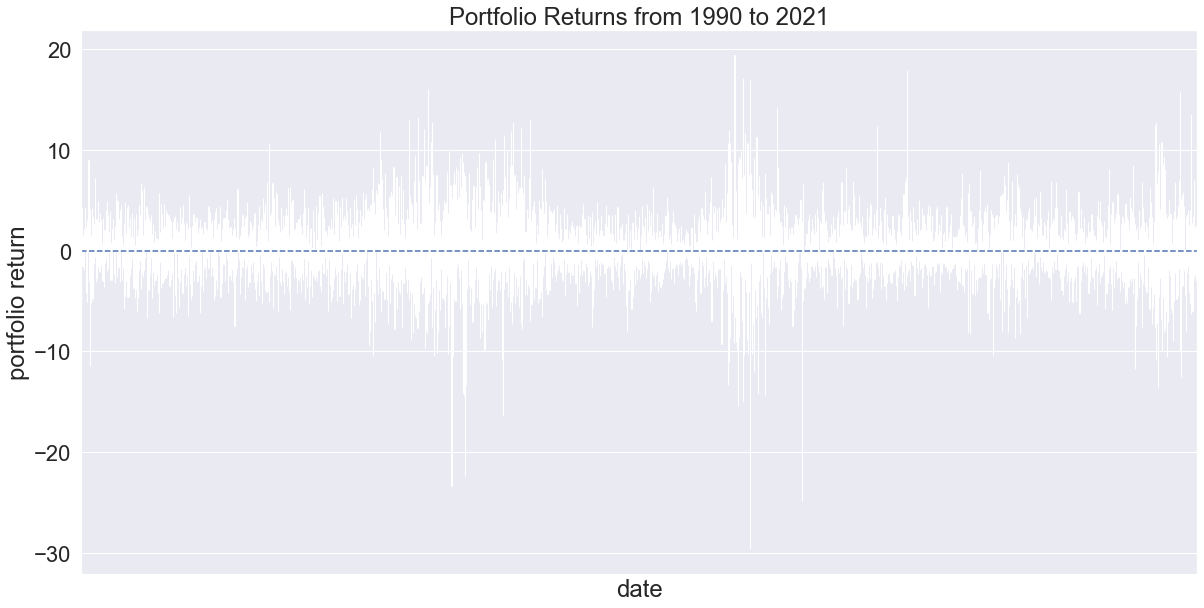

In [130]:
fig, axes = plt.subplots(figsize=(20,10))
sns.barplot(data=portfolio_200.reset_index(), x="date", y="portfolio return", color = 'grey')

axes.xaxis.set_major_locator(mdates.YearLocator())
myFmt = mdates.DateFormatter("%Y")
axes.xaxis.set_major_formatter(myFmt)

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns from 1990 to 2021')

sns.set(font_scale=2)
plt.axhline(0, ls="--")

plt.show()

In [131]:
portfolio_200['30_day_avg'] = portfolio_200['portfolio return'].rolling(30).mean()

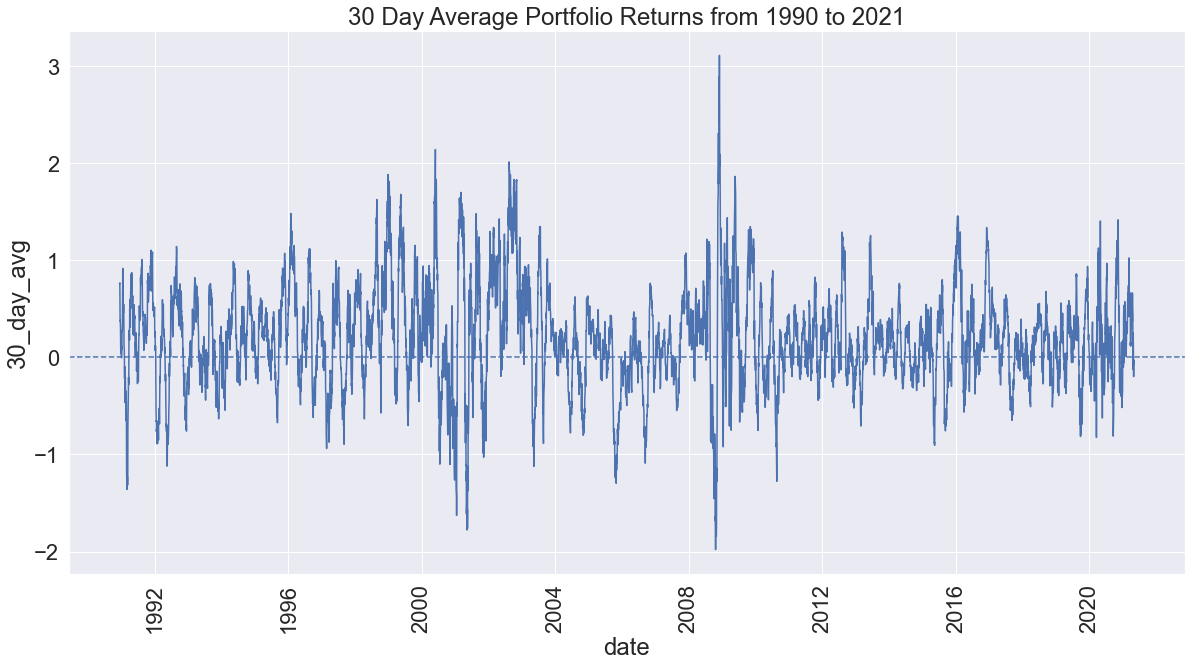

In [138]:
fig, axes = plt.subplots(figsize=(20,10))
sns.lineplot(data=portfolio_200.dropna(), x="date", y="30_day_avg")

axes.set_title('30 Day Average Portfolio Returns from 1990 to 2021')
plt.xticks(rotation = 'vertical')
plt.axhline(0, ls="--")

In [139]:
total_avg = portfolio_200['portfolio return'].mean()
print(f'Total average return is: {total_avg:.2f} %')

Total average return is: 0.20 %
